In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use("~/.base_style.mplstyle")

In [2]:
data = pd.read_csv("data/ecdc_full_data.csv")
data = (
    data[
        data.location.isin(
            [
                "World",
                "France",
                "China",
                "United States",
                "Sweden",
                "Denmark",
                "Italy",
                "Spain",
                "United Kingdom",
                "Germany",
            ]
        )
    ]
    .loc[
        :,
        [
            "date",
            "location",
            "new_cases_smoothed",
            "total_cases",
            "new_deaths_smoothed",
            "total_deaths",
        ],
    ]
    .rename(
        columns={"new_cases_smoothed": "new_cases", "new_deaths_smoothed": "new_deaths"}
    )
    .dropna()
)
data.loc[:, ["new_cases", "new_deaths"]] = data.loc[
    :, ["new_cases", "new_deaths"]
].astype("int")
data["date"] = data.date.apply(pd.to_datetime)
data["date_str"] = data.date.apply(lambda x: x.strftime("%d/%m/%Y"))

In [3]:
dataf = data[data.location == "France"]

In [4]:
df = data[data.location != "World"]

In [5]:
df = df.groupby("location").filter(lambda x: x.total_cases.values[-1] > 10000)

In [6]:
df.head()

,date,location,new_cases,total_cases,new_deaths,total_deaths,date_str
10187,2020-01-28,China,708,5509.0,16,131.0,28/01/2020
10188,2020-01-29,China,791,6087.0,16,133.0,29/01/2020
10189,2020-01-30,China,1071,8141.0,21,171.0,30/01/2020
10190,2020-01-31,China,1268,9802.0,26,213.0,31/01/2020
10191,2020-02-01,China,1497,11891.0,31,259.0,01/02/2020


In [78]:
res = sm.RLM(endog=dataf["new_deaths"], exog=dataf[["new_cases"]]).fit()

In [85]:
res.resid.sum() / dataf["new_deaths"].var()

0.5957116530958775

<AxesSubplot:xlabel='new_cases', ylabel='new_deaths'>

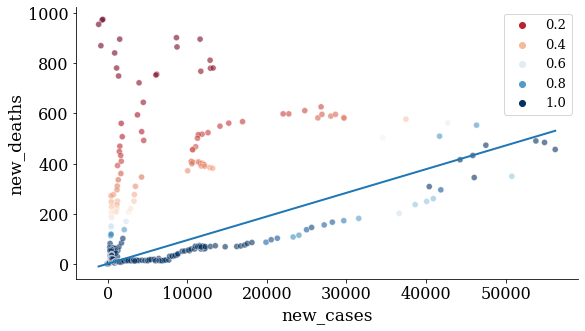

In [79]:
sns.scatterplot(x=dataf["new_cases"], y=dataf["new_deaths"], hue=res.weights, palette="RdBu", alpha=0.6)
sns.lineplot(x=dataf["new_cases"], y=res.fittedvalues)

In [225]:
def compute_pearson(x, shift=k):
    return stats.pearsonr(x.new_cases.shift(k).dropna(), x.new_deaths[k:])[0]

def get_residual(x, shift=k):
    res.resid.sum() / dataf["new_deaths"].var()


In [226]:
pears = df.groupby("location").apply(lambda x: compute_pearson(x, 2))
pears[pears.isna()]

Series([], dtype: float64)

In [234]:
p_ = []
for k in range(20):
    p = df.groupby("location").apply(lambda x: compute_pearson(x, 2))
    p = p.dropna()
    p_.append(p.mean())

In [235]:
p_ = np.stack(p_)

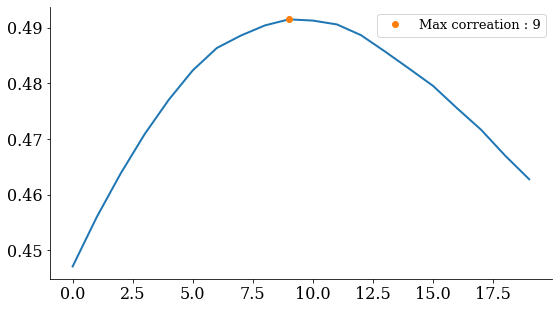

In [236]:
plt.plot(p_);
plt.plot(np.argmax(p_), np.max(p_), 'o', label=f"Max correation : {np.argmax(p_)}")
plt.legend();